In [60]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from utils import load_embedded_data

Here, we inspect the classification performance of maximizing $p(y \mid x, t)$ over $y$ and $t$.

In [61]:
X_train, y_train, X_test, y_test = load_embedded_data(split_train=True, split_test=True)

X_train shape: (10, 5000, 1000)
y_train shape: (10, 5000, 1)
X_test shape: (10, 1000, 1000)
y_test shape: (10, 1000, 1)


In [62]:
task_cond_probs = pickle.load(open("output/task_cond_probs.p", "rb"))

# Should be n_test = 10*1000 by 10*10 = 100
print("Task conditional probs shape:", task_cond_probs.shape)

Task conditional probs shape: (10000, 100)


In [63]:
# Within task accuracy.
task_aware_acc = []
for t in range(10):
    print("TASK", t)
    print("----------------")
    
    data_start, data_end = t * 1000, (t+1) * 1000
    classes_start, classes_end = t * 10, (t+1) * 10
    
    posterior = task_cond_probs[data_start : data_end, classes_start : classes_end]
    y_pred = np.argmax(posterior, axis = 1)
    y_true = np.mod(y_test[t], 10)
    acc = accuracy_score(y_true, y_pred)
    task_aware_acc.append(acc)
    print("Test accuracy: ", acc)
pickle.dump(np.mean(task_aware_acc), open("output/task_aware_acc.p", "wb"))

TASK 0
----------------
Test accuracy:  0.843
TASK 1
----------------
Test accuracy:  0.832
TASK 2
----------------
Test accuracy:  0.833
TASK 3
----------------
Test accuracy:  0.805
TASK 4
----------------
Test accuracy:  0.82
TASK 5
----------------
Test accuracy:  0.76
TASK 6
----------------
Test accuracy:  0.766
TASK 7
----------------
Test accuracy:  0.788
TASK 8
----------------
Test accuracy:  0.828
TASK 9
----------------
Test accuracy:  0.854


Compute the accuracy of unweighted argmax across all posteriors $p(y | x, t)$

In [64]:
X_train, y_train, X_test, y_test = load_embedded_data(split_test=False)

y_pred = np.argmax(task_cond_probs, axis = 1)

unweighted_acc = accuracy_score(y_test, y_pred)

pickle.dump(unweighted_acc, open("output/unweighted_acc.p", "wb"))

print("Accuracy of argmax_{y, t} p(y | x, t):", unweighted_acc)

X_train shape: (50000, 1000)
y_train shape: (50000, 1)
X_test shape: (10000, 1000)
y_test shape: (10000, 1)
Accuracy of argmax_{y, t} p(y | x, t): 0.3024


Here, we inspect the classification performance of maximizing $\sum_t p(y \mid x, t) p(t \mid x)$ over $y$.

In [72]:
priors = pickle.load(open("output/task_priors.p", "rb"))

# Should be 10*n by 10 (num_tasks), where n is the number of points per task (1000) 
print("priors shape:", priors.shape)
print("task_cond_probs shape:", task_cond_probs.shape)
print("y_test shape:", y_test.shape)

priors shape: (10000, 10)
task_cond_probs shape: (10000, 100)
y_test shape: (10000, 1)


In [73]:
n_test = 10000
n_classes = 100

posterior = np.zeros((n_test, n_classes))
prior_pred = np.argmax(priors, axis=1)

for i in range(n_test):
    for j in range(n_classes):
        if prior_pred[i] == (j // 10):
            posterior[i, j] = task_cond_probs[i, j]

In [74]:
y_pred_weighted = np.argmax(posterior, axis=1)

weighted_acc = accuracy_score(y_test, y_pred_weighted)

pickle.dump(weighted_acc, open("output/weighted_acc.p", "wb"))

print("Accuracy of argmax_y sum_t p(y | x, t) p(t | x):", weighted_acc)

Accuracy of argmax_y sum_t p(y | x, t) p(t | x): 0.4965


In [75]:
# Average single task accuracy
uf_probs = pickle.load(open("output/uf_probs.p", "rb"))

X_train, y_train, X_test, y_test = load_embedded_data(split_test=True)

single_task_acc = []
for t in range(10):
    y_pred_t = np.argmax(uf_probs[t], axis=1)
    y_true = np.mod(y_test[t], 10)
    acc = accuracy_score(y_true, y_pred_t)
    single_task_acc.append(acc)
    print("Task %d accuracy: %f." % (t, acc))
    
pickle.dump(single_task_acc, open("output/single_task_acc.p", "wb"))

X_train shape: (50000, 1000)
y_train shape: (50000, 1)
X_test shape: (10, 1000, 1000)
y_test shape: (10, 1000, 1)
Task 0 accuracy: 0.877000.
Task 1 accuracy: 0.840000.
Task 2 accuracy: 0.853000.
Task 3 accuracy: 0.836000.
Task 4 accuracy: 0.831000.
Task 5 accuracy: 0.780000.
Task 6 accuracy: 0.784000.
Task 7 accuracy: 0.794000.
Task 8 accuracy: 0.859000.
Task 9 accuracy: 0.859000.


In [76]:
te_array = (1 - np.array(single_task_acc)) / (1 - np.array(task_aware_acc))

pickle.dump(te_array, open("output/te_array.p", "wb"))

In [59]:
print("Split-CIFAR 10x10:")
print("-----------------------------------------")
print("n_estimators = 300, n_train = 5000")
for t in range(10):
    print('Task %d: UF acc: %f; LF acc: %f' % (t, single_task_acc[t], task_aware_acc[t]))

Split-CIFAR 10x10:
-----------------------------------------
n_estimators = 300, n_train = 5000
Task 0: UF acc: 0.877000; LF acc: 0.843000
Task 1: UF acc: 0.840000; LF acc: 0.832000
Task 2: UF acc: 0.853000; LF acc: 0.833000
Task 3: UF acc: 0.836000; LF acc: 0.805000
Task 4: UF acc: 0.831000; LF acc: 0.820000
Task 5: UF acc: 0.780000; LF acc: 0.760000
Task 6: UF acc: 0.784000; LF acc: 0.766000
Task 7: UF acc: 0.794000; LF acc: 0.788000
Task 8: UF acc: 0.859000; LF acc: 0.828000
Task 9: UF acc: 0.859000; LF acc: 0.854000


In [46]:
def plot_te():
    x = np.arange(10)
    
    te_array = pickle.load(open("output/te_array.p", "rb"))

    ax = plt.subplot(111)
    ax.bar(x, te_array, width=0.2, color='gray', align='center')
    
    ax.set_xticks(x)
    # ax.set_xticklabels([('Task %d' % t) for t in range(10)])
    
    ax.set_xlabel("Task")
    ax.set_ylabel("Transfer Efficiency")
    ax.set_ylim(0, 2)
    
    ax.axhline(y=1, linestyle='--', color = 'k')

    ax.set_title("L2F+ResNet50 Encoded Split-CIFAR, n_trees=300, n_train=5000")
    plt.savefig("te_fig.pdf", bbox_inches = "tight")
    plt.show()

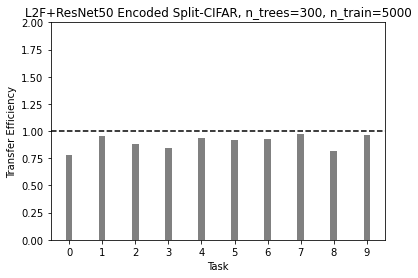

In [47]:
plot_te()

In [77]:
def plot_result():
    x = 0.5*np.array([0, 1, 2, 3, 4])
    
    cifar100_acc = pickle.load(open("output/cifar100_lf_acc.p", "rb"))
    unweighted_acc = pickle.load(open("output/unweighted_acc.p", "rb"))
    weighted_acc = pickle.load(open("output/weighted_acc.p", "rb"))
    task_aware_acc_mean = np.mean(pickle.load(open("output/task_aware_acc.p", "rb")))
    single_task_acc_mean = np.mean(pickle.load(open("output/single_task_acc.p", "rb")))
    
    accs = [cifar100_acc, unweighted_acc, weighted_acc, task_aware_acc_mean, single_task_acc_mean]

    ax = plt.subplot(111)
    ax.bar(x, accs, width=0.2, color='gray', align='center')
    
    ax.set_xticks(x)
    ax.set_xticklabels(['100 Class', 'Unweighted', 'Weighted', 'Task Aware', 'Single Task'])
    
    ax.set_ylabel("Accuracy on CIFAR 100")
    ax.set_ylim(0, 1)
    
    ax.axhline(y=0.01, linestyle='--', color = 'k', label = 'Chance')
    ax.legend(loc = 'upper right')

    plt.savefig("cifar100_task_obl_fig.pdf", bbox_inches = "tight")
    plt.show()

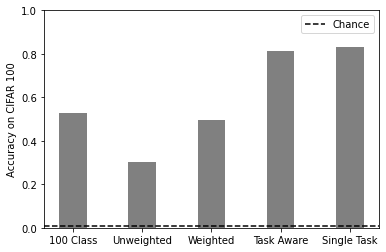

In [78]:
plot_result()